In [248]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import prince
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB

In [249]:
train_data = pd.read_csv('training set values.csv')
train_target = pd.read_csv('training set labels.csv')


In [250]:
# Merge data and labels together in one dataframe.
train_data = pd.merge(train_data, train_target, on='id')
del train_target

In [251]:
# Explore data set.

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

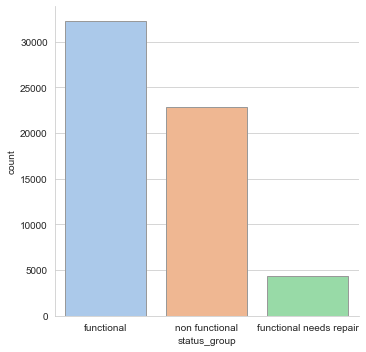

In [252]:
sns.catplot(x="status_group", kind="count",palette="pastel", edgecolor=".6",data=train_data)

In [253]:
train_data.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [254]:
# Check for nulls.

train_data.apply(lambda x: sum(x.isnull()))

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [255]:
# Deal with the columns containing null values one by one. Start with 'funder'.

train_data.funder.value_counts()

Government Of Tanzania            9084
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
                                  ... 
Rc Missi                             1
Tgrs                                 1
Dhv\swis                             1
Rotary Club Of Chico And Moshi       1
Unice/ Cspd                          1
Name: funder, Length: 1897, dtype: int64

In [256]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def funder_wrangler(row):  
    '''Keep top 10 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'gov'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank' 
    elif row['funder']=='Kkkt':
        return 'Kkkt'
    elif row['funder']=='World Vision ':
        return 'World_Vision '
    elif row['funder']=='Unicef':
        return 'Unicef'
    elif row['funder']=='Tasaf':
        return 'Tasaf'
    elif row['funder']=='District Council':
        return 'Dis_Council'
    else:
        return 'other'
    
train_data['funder'] = train_data.apply(lambda row: funder_wrangler(row), axis=1)

In [257]:
# Add column named 'status_group_vals' to allow the use of a pivot table to check differences
# between the different funders.

vals_to_replace = {'functional':2, 'functional needs repair':1,
                   'non functional':0}

train_data['status_group_vals']  = train_data.status_group.replace(vals_to_replace)

In [258]:
per = train_data.groupby(['funder','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('funder')
per.head(10)


status_group,functional,functional needs repair,non functional
funder,,,
Dis_Council,378,45,420
Kkkt,723,66,498
Tasaf,493,64,320
Unicef,600,99,358
danida,1713,159,1242
gov,3720,701,4663
hesawa,936,232,1034
other,22346,2745,13122
rwssp,805,109,460


In [259]:
per['total'] = per.sum(axis=1)

per









status_group,functional,functional needs repair,non functional,total
funder,,,,
Dis_Council,378,45,420,843
Kkkt,723,66,498,1287
Tasaf,493,64,320,877
Unicef,600,99,358,1057
danida,1713,159,1242,3114
gov,3720,701,4663,9084
hesawa,936,232,1034,2202
other,22346,2745,13122,38213
rwssp,805,109,460,1374


In [260]:
def percentage_share(df):
    for i in df.columns:
        df[i] = df.apply(lambda row: (row[i]/row['total']*100), axis=1) 
    df.drop('total',inplace=True,axis=1)
    return df

per_df = percentage_share(per) 

per_df

status_group,functional,functional needs repair,non functional
funder,,,
Dis_Council,44.839858,5.338078,49.822064
Kkkt,56.177156,5.128205,38.694639
Tasaf,56.214367,7.297605,36.488027
Unicef,56.764428,9.366131,33.869442
danida,55.009634,5.105973,39.884393
gov,40.951123,7.716865,51.332012
hesawa,42.506812,10.535876,46.957312
other,58.477481,7.183419,34.339099
rwssp,58.588064,7.933042,33.478894


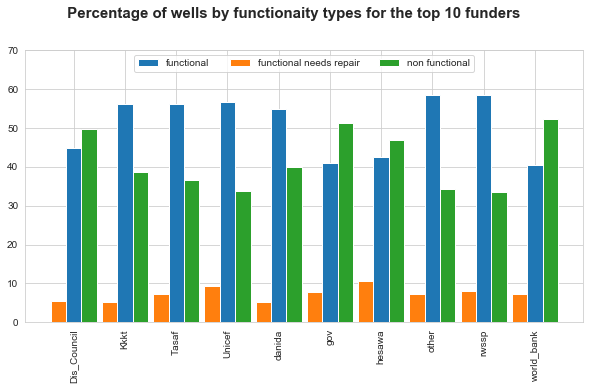

In [261]:
funder = [0,1,2,3,4,5,6,7,8,9]
functional = per_df['functional']
nr_functional = per_df['functional needs repair']
n_functional = per_df['non functional']
header = per_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(funder)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_ylim(0,70)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='Dis_Council'
xlab[1]='Kkkt'
xlab[2]='Tasaf'
xlab[3]='Unicef'
xlab[4]='danida'
xlab[5]='gov'
xlab[6] ='hesawa'
xlab[7]='other'
xlab[8]='rwssp'
xlab[9] ='world_bank'


#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)

#for i,v in enumerate(functional):
    #.text(i-.25,v+10,functional[i],fomtsize=8)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for the top 10 funders  '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

In [262]:
# There are some clear differences here that will hopefully improve the model. The next feature
# to inspect is 'installer'.

train_data.installer.value_counts()

DWE                             17402
Government                       1825
RWE                              1206
Commu                            1060
DANIDA                           1050
                                ...  
TINA/Africare                       1
Tanz/Egypt technical coopera        1
AGRICAN                             1
George mtoto company                1
Birage                              1
Name: installer, Length: 2145, dtype: int64

In [263]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def installer_wrangler(row):
    '''Keep top 7 values and set the rest to 'other'''
    if row['installer']=='DWE':
        return 'dwe'
    elif row['installer']=='Government':
        return 'gov'
    elif row['installer']=='RWE':
        return 'rwe'
    elif row['installer']=='Commu':
        return 'commu'
    elif row['installer']=='DANIDA':
        return 'danida'
    elif row['installer']=='KKKT ':
        return 'KKKT '
    elif row['installer']=='Hesawa':
        return 'Hesawa'
    
    else:
        return 'other'  

train_data['installer'] = train_data.apply(lambda row: installer_wrangler(row), axis=1)

In [264]:
per_inst = train_data.groupby(['installer','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('installer')
per_inst.head(7)

status_group,functional,functional needs repair,non functional
installer,,,
Hesawa,475,17,348
commu,724,32,304
danida,542,83,425
dwe,9433,1622,6347
gov,535,256,1034
other,20246,2170,13601
rwe,304,137,765


In [265]:
per_inst['total'] = per_inst.sum(axis=1)

per_inst

status_group,functional,functional needs repair,non functional,total
installer,,,,
Hesawa,475,17,348,840
commu,724,32,304,1060
danida,542,83,425,1050
dwe,9433,1622,6347,17402
gov,535,256,1034,1825
other,20246,2170,13601,36017
rwe,304,137,765,1206


In [266]:
perinst_df = percentage_share(per_inst) 

perinst_df

status_group,functional,functional needs repair,non functional
installer,,,
Hesawa,56.547619,2.023810,41.428571
commu,68.301887,3.018868,28.679245
danida,51.619048,7.904762,40.476190
dwe,54.206413,9.320768,36.472819
gov,29.315068,14.027397,56.657534
other,56.212344,6.024933,37.762723
rwe,25.207297,11.359867,63.432836


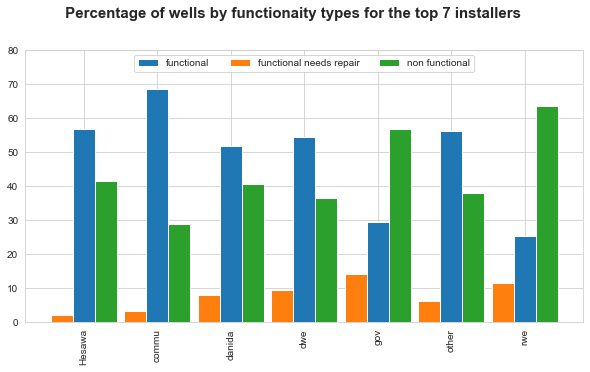

In [267]:
installer = [0,1,2,3,4,5,6]
functional = perinst_df['functional']
nr_functional = perinst_df['functional needs repair']
n_functional = perinst_df['non functional']
header = perinst_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(installer)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_ylim(0,80)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='Hesawa'
xlab[1]='commu'
xlab[2]='danida'
xlab[3]='dwe'
xlab[4]='gov'
xlab[5]='other'
xlab[6] ='rwe'



#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for the top 7 installers  '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

In [268]:
# As was the case with 'funder' there are some clear differences here that will hopefully
# improve the model. The next feature to inspect is 'subvillage'.

print(train_data.subvillage.value_counts())

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Kwasekibaja      1
Nyagudi          1
Itembe           1
Daghaseta        1
Mwamazengo       1
Name: subvillage, Length: 19287, dtype: int64


In [269]:
print('Number of villages: ', len(train_data.subvillage.value_counts()))

Number of villages:  19287


In [270]:
# 19287 unique values! The largest values don't dominate as was the case with installer and
# funder. It's probably not worth creating dummy variables for the top 5. I'll drop this one but
# feel free to experiment here.

train_data.drop('subvillage',inplace = True, axis=1)

In [271]:
# Let's investigate the next column containg null data: 'public_meeting'.

train_data.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [272]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

train_data.public_meeting = train_data.public_meeting.fillna('Unknown')

In [273]:
train_data.public_meeting.head(20)

0        True
1     Unknown
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18    Unknown
19       True
Name: public_meeting, dtype: object

In [274]:

train_data.scheme_management.value_counts()


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [275]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def scheme_wrangler(row):
    '''Keep top 8 values and set the rest to 'other'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    elif row['scheme_management']=='Parastatal':
        return 'Parastatal'
    elif row['scheme_management']=='Private operator':
        return 'pri_opr'
    elif row['scheme_management']=='Company':
        return 'comp'
    else:
        return 'other'

train_data['scheme_management'] = train_data.apply(lambda row: scheme_wrangler(row), axis=1)

In [276]:
per_sch_mgmt = train_data.groupby(['scheme_management','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('scheme_management')
per_sch_mgmt.head(8)

status_group,functional,functional needs repair,non functional
scheme_management,,,
Parastatal,966,202,512
comp,534,37,490
other,2398,251,2164
pri_opr,729,23,311
vwc,18960,2334,15499
wtr_auth,1618,448,1087
wtr_brd,2053,111,584
wua,1995,239,649


In [277]:
per_sch_mgmt['total'] = per_sch_mgmt.sum(axis=1)

per_sch_mgmt

status_group,functional,functional needs repair,non functional,total
scheme_management,,,,
Parastatal,966,202,512,1680
comp,534,37,490,1061
other,2398,251,2164,4813
pri_opr,729,23,311,1063
vwc,18960,2334,15499,36793
wtr_auth,1618,448,1087,3153
wtr_brd,2053,111,584,2748
wua,1995,239,649,2883
wug,3006,672,1528,5206


In [278]:
#calculating the percentage
per_sch_mgmt_df = percentage_share(per_sch_mgmt) 

per_sch_mgmt_df

status_group,functional,functional needs repair,non functional
scheme_management,,,
Parastatal,57.500000,12.023810,30.476190
comp,50.329877,3.487276,46.182846
other,49.823395,5.215043,44.961562
pri_opr,68.579492,2.163688,29.256820
vwc,51.531541,6.343598,42.124861
wtr_auth,51.316207,14.208690,34.475103
wtr_brd,74.708879,4.039301,21.251820
wua,69.198751,8.289976,22.511273
wug,57.741068,12.908183,29.350749


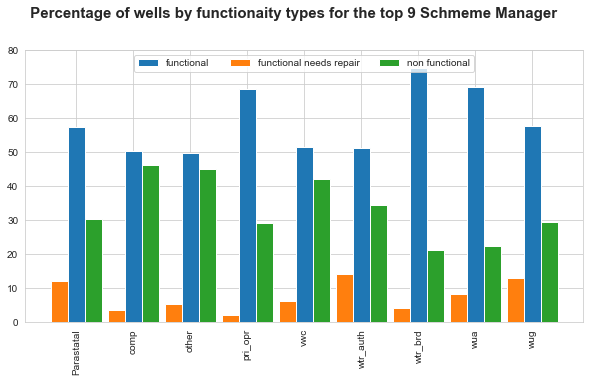

In [279]:
scheme_management = [0,1,2,3,4,5,6,7,8]
functional = per_sch_mgmt_df['functional']
nr_functional = per_sch_mgmt_df['functional needs repair']
n_functional = per_sch_mgmt_df['non functional']
header = per_sch_mgmt_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(scheme_management)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_ylim(0,80)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='Parastatal'
xlab[1]='comp'
xlab[2]='other'
xlab[3]='pri_opr'
xlab[4]='vwc'
xlab[5]='wtr_auth'
xlab[6] ='wtr_brd'
xlab[7] ='wua'
xlab[8] ='wug'



#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)

#for i,v in enumerate(functional):
    #.text(i-.25,v+10,functional[i],fomtsize=8)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for the top 9 Schmeme Manager  '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

In [280]:
train_data.scheme_name.value_counts()

K                         682
None                      644
Borehole                  546
Chalinze wate             405
M                         400
                         ... 
Michee Borehole Scheme      1
Mirumba                     1
Hivuga Water Supply         1
Kayugi spring source        1
Mugoma spring source        1
Name: scheme_name, Length: 2696, dtype: int64

In [281]:
len(train_data.scheme_name.unique())

2697

In [282]:
# Lots of factors and the top 5 or so only represent a fraction of the total values. Probably 
# safe to drop this column.

train_data.drop('scheme_name',inplace = True , axis=1)

In [283]:
# The final column containing nulls is 'permit'.

train_data.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [284]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

train_data.permit = train_data.permit.fillna('Unknown')

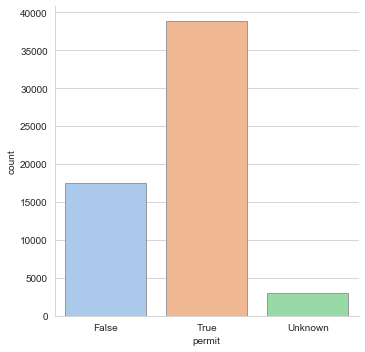

In [285]:
sns.catplot(x="permit", kind="count",palette="pastel", edgecolor=".6",data=train_data)

In [286]:
# Excellent! Now there are no nulls in the data set. We can move on to look at columns with 
# string values and modify or remove them as we see fit.

str_cols = train_data.select_dtypes(include = ['object'])
str_cols.apply(lambda x: len(x.unique()))

date_recorded              356
funder                      10
installer                    7
wpt_name                 37400
basin                        9
region                      21
lga                        125
ward                      2092
public_meeting               3
recorded_by                  1
scheme_management            9
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

In [287]:

train_data.apply(lambda x: sum(x.isnull()))

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

In [288]:
# 'Date recorded'

train_data.date_recorded.describe()

count          59400
unique           356
top       2011-03-15
freq             572
Name: date_recorded, dtype: object

In [289]:
import datetime

In [290]:
train_data['year'] = pd.DatetimeIndex(train_data['date_recorded']).year

In [291]:
op_years = list(train_data.year-train_data.construction_year)
operational_years = []
for i in op_years:
    if (i > 500) or (i < 0):
        operational_years.append(0)
    else:
        operational_years.append(i)
train_data['operational_years'] = operational_years

In [292]:
train_data.operational_years

0        12
1         3
2         4
3        27
4         0
         ..
59395    14
59396    15
59397     0
59398     0
59399     9
Name: operational_years, Length: 59400, dtype: int64

In [293]:
piv_table = pd.pivot_table(train_data, index=['operational_years', 'status_group'],
                           values=['status_group_vals'], aggfunc='count')
piv_table

status_group_vals
operational_years status_group                              
0                 functional                           10972
                  functional needs repair               1800
                  non functional                        8534
1                 functional                            1754
                  functional needs repair                 66
...                                                      ...
52                functional needs repair                  3
                  non functional                           7
53                functional                              23
                  functional needs repair                  6
                  non functional                          62

[160 rows x 1 columns]

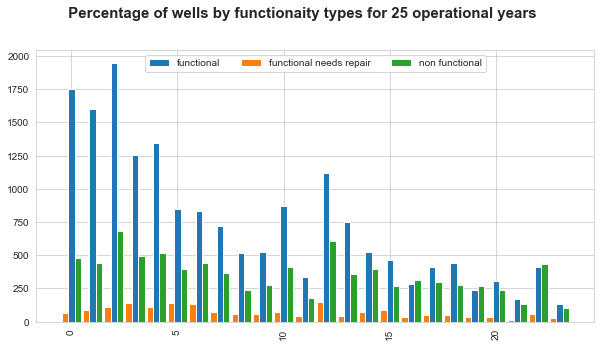

In [294]:
yr = []
functional = []
nr_functional = []
n_functional = []

for i in range(1,25):
    yr.append(i)
    functional.append(piv_table.loc[i].loc['functional'][0])
    nr_functional.append(piv_table.loc[i].loc['functional needs repair'][0])
    n_functional.append(piv_table.loc[i].loc['non functional'][0])
    
    
    
header = per_sch_mgmt_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(yr)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)



for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for 25 operational years   '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()
   

In [295]:
train_data.drop('date_recorded',inplace = True , axis=1)

In [296]:
train_data.drop('year',inplace = True , axis=1)

In [297]:
# There's a wide range of data here hopefully it will help improve the predictive power of our
# models. Next up for inspection is 'wpt_name' (Name of the waterpoint if there is one).

train_data.wpt_name.value_counts()

none                         3563
Shuleni                      1748
Zahanati                      830
Msikitini                     535
Kanisani                      323
                             ... 
Kwa Keneth Mlimbila             1
Mchinga Ii Primary School       1
Ipoja                           1
Arkaria Primary School          1
Kwa Fiderick Ipanta             1
Name: wpt_name, Length: 37400, dtype: int64

In [298]:
# Due to the huge number of factors and the lack of a clear dominating value I'll drop this.
# I may come back and include the top 5 later. Next up is 'basin'.

train_data.drop('wpt_name',inplace = True , axis=1)

In [299]:
train_data.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [300]:
piv_table = pd.pivot_table(train_data, index=['basin', 'status_group'],
                           values=['status_group_vals'], aggfunc='count')
piv_table

status_group_vals
basin                   status_group                              
Internal                functional                            4482
                        functional needs repair                557
                        non functional                        2746
Lake Nyasa              functional                            3324
                        functional needs repair                250
                        non functional                        1511
Lake Rukwa              functional                            1000
                        functional needs repair                270
                        non functional                        1184
Lake Tanganyika         functional                            3107
                        functional needs repair                742
                        non functional                        2583
Lake Victoria           functional                            5100
                        functional needs repair                989
                        non functional                        4159
Pangani                 functional                            5372
                        functional needs repair                477
                        non functional                        3091
Rufiji                  functional                            5068
                        functional needs repair                437
                        non functional                        2471
Ruvuma / Southern Coast functional                            1670
                        functional needs repair                326
                        non functional                        2497
Wami / Ruvu             functional                            3136
                        functional needs repair                269
                        non functional                        2582

In [301]:
# Most basins have have more functional than non-functional pumps. Lake Rukwa
# and Ruvuma don't. All the values are over 2000 so this looks like a good feature to keep.
# Region will be considered next.

In [302]:

train_data.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [303]:
# Both basin, lga, ward and region contain geographical information so there is a risk of them being
# highly correlated with each other. I'll drop then for now.
# They could be be worth including though, so I may come back to them.
train_data.drop(['region', 'lga', 'ward'],inplace = True, axis=1)

In [304]:
train_data.recorded_by.value_counts().describe()

count        1.0
mean     59400.0
std          NaN
min      59400.0
25%      59400.0
50%      59400.0
75%      59400.0
max      59400.0
Name: recorded_by, dtype: float64

In [305]:
# All data points have the same value so this offers no information that would help build our
# model.
train_data.drop('recorded_by',inplace = True, axis=1)

In [306]:
# extraction_type, extraction_type_group and extraction_type_class appear to contain very similar
# data. I'll drop the first two and keep the last one.

train_data.drop(['extraction_type', 'extraction_type_group'],inplace = True, axis=1)

In [307]:
train_data.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [308]:
# This appears to be almost identical to 'scheme_management'. I'll drop it.

train_data.drop('management',inplace = True, axis=1)

In [309]:
train_data.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [310]:
train_data.scheme_management.unique()

array(['vwc', 'other', 'pri_opr', 'wug', 'wtr_brd', 'wua', 'wtr_auth',
       'comp', 'Parastatal'], dtype=object)

In [311]:
# Appears to offer no new info and is likely to overlap with 'scheme_management'.

train_data.drop('management_group',inplace = True, axis=1)

In [312]:
train_data.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [313]:
train_data.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [314]:
# Payment and payment_type contain identical data. Remove one and keep the other.

train_data.drop('payment',inplace = True, axis=1)

In [315]:

train_data.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [316]:
train_data.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

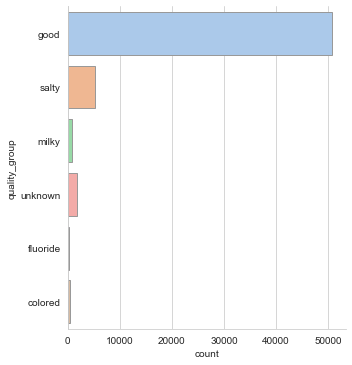

In [317]:
sns.catplot(y="quality_group", kind="count",palette="pastel", edgecolor=".6",data=train_data)

In [318]:
piv_table = pd.pivot_table(train_data, index=['quality_group', 'status_group'],
                           values=['status_group_vals'], aggfunc='count')

piv_table

status_group_vals
quality_group status_group                              
colored       functional                             246
              functional needs repair                 54
              non functional                         190
fluoride      functional                             157
              functional needs repair                 13
              non functional                          47
good          functional                           28760
              functional needs repair               3904
              non functional                       18154
milky         functional                             438
              functional needs repair                 14
              non functional                         352
salty         functional                            2394
              functional needs repair                297
              non functional                        2504
unknown       functional                             264
              functional needs repair                 35
              non functional                        1577

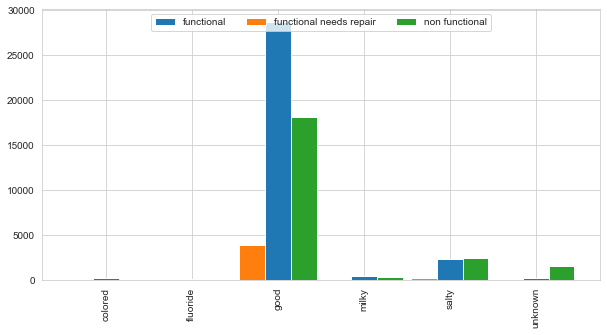

In [319]:
quality_group = [0,1,2,3,4,5]
functional = [246,157,28760,438,2394,264]
nr_functional = [54,13,3904,14,297,35]
n_functional = [190,47,18154,352,2504,1577]



fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(quality_group)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[1]='colored'
xlab[2]='fluoride'
xlab[3]='good'
xlab[4]='milky'
xlab[5]='salty'
xlab[6]='unknown'
ax.set_xticklabels(xlab)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure

plt.show()

In [320]:
# Water_quality and quality_group contain identical data. Remove one and keep the other.

train_data.drop('water_quality',inplace = True, axis = 1)

In [321]:
train_data.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [322]:
piv_table = pd.pivot_table(train_data, index=['quantity', 'status_group'],
                           values=['status_group_vals'], aggfunc='count')

piv_table

status_group_vals
quantity     status_group                              
dry          functional                             157
             functional needs repair                 37
             non functional                        6052
enough       functional                           21648
             functional needs repair               2400
             non functional                        9138
insufficient functional                            7916
             functional needs repair               1450
             non functional                        5763
seasonal     functional                            2325
             functional needs repair                416
             non functional                        1309
unknown      functional                             213
             functional needs repair                 14
             non functional                         562

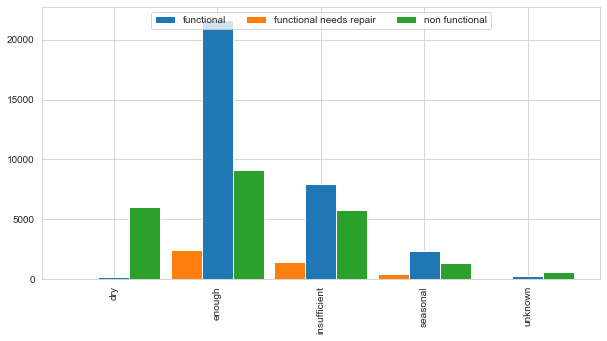

In [323]:
quantity = [0,1,2,3,4]
functional = [157,21648,7916,2325,213]
nr_functional = [37,2400,1450,416,14]
n_functional = [6052,9138,5763,1309,562]



fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(quantity)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[1]='dry'
xlab[2]='enough'
xlab[3]='insufficient'
xlab[4]='seasonal'
xlab[5]='unknown'
ax.set_xticklabels(xlab)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure

plt.show()

In [324]:
train_data.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [325]:
# Quantity and quantity_group contain identical data. Remove one and keep the other.

train_data.drop('quantity_group',inplace = True,axis = 1)

In [326]:
train_data.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [327]:
train_data.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [328]:
train_data.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [329]:
piv_table = pd.pivot_table(train_data, index=['source_type', 'status_group'],
                           values=['status_group_vals'], aggfunc='count')

piv_table

status_group_vals
source_type          status_group                              
borehole             functional                            5919
                     functional needs repair                508
                     non functional                        5522
dam                  functional                             253
                     functional needs repair                 24
                     non functional                         379
other                functional                             158
                     functional needs repair                  5
                     non functional                         115
rainwater harvesting functional                            1386
                     functional needs repair                314
                     non functional                         595
river/lake           functional                            5627
                     functional needs repair               1233
                     non functional                        3517
shallow well         functional                            8324
                     functional needs repair                957
                     non functional                        7543
spring               functional                           10592
                     functional needs repair               1276
                     non functional                        5153

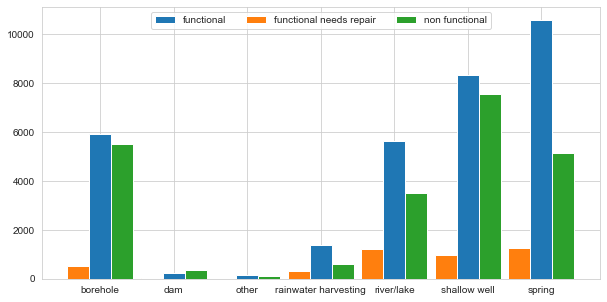

In [330]:
source_type = [0,1,2,3,4,5,6]
functional = [5919,253,158,1386,5627,8324,10592]
nr_functional = [508,24,5,314,1233,957,1276]
n_functional = [5522,379,115,595,3517,7543,5153]



fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(source_type)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[1]='borehole'
xlab[2]='dam'
xlab[3]='other'
xlab[4]='rainwater harvesting'
xlab[5]='river/lake'
xlab[6]='shallow well'
xlab[7]='spring'
ax.set_xticklabels(xlab)


#for tick in ax.get_xticklabels():
    #tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure

plt.show()

In [331]:
# Source and source_type contain very similar information. Remove one and keep the other.

train_data.drop('source',inplace = True,axis =  1)

In [332]:
# gps_height, longitude, latitude, region_code and district_code are all geographic info which
# is unlikely to add any predictive power to the model given that there are other variables
# containing geographic data. 'num_private' hasn't been given a discription on Driven Data,
# it appears to be superflous. We expect id to not contain any useful information so that gets
# dropped too.

train_data.drop(['gps_height','longitude','latitude','region_code', 'district_code',
             'num_private', 'id'], inplace = True,axis=1)

In [333]:
train_data.describe()


,amount_tsh,population,construction_year,status_group_vals,operational_years
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,179.909983,1300.652475,1.158838,10.002778
std,2997.574558,471.482176,951.620547,0.949794,12.457472
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,25.000000,1986.000000,2.000000,4.000000
75%,20.000000,215.000000,2004.000000,2.000000,16.000000
max,350000.000000,30500.000000,2013.000000,2.000000,53.000000


In [334]:
train_data.apply(lambda x: len(x.unique()))

amount_tsh                 98
funder                     10
installer                   7
basin                       9
population               1049
public_meeting              3
scheme_management           9
permit                      3
construction_year          55
extraction_type_class       7
payment_type                7
quality_group               6
quantity                    5
source_type                 7
source_class                3
waterpoint_type             7
waterpoint_type_group       6
status_group                3
status_group_vals           3
operational_years          54
dtype: int64

In [335]:
train_data.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [336]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train_data['construction_year'] = train_data.apply(lambda row: construction_wrangler(row), axis=1)

In [337]:
per_con_yr = train_data.groupby(['construction_year','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('construction_year')
per_con_yr.head(8)

status_group,functional,functional needs repair,non functional
construction_year,,,
00s,9989,977,4364
10s,3794,220,1147
60s,156,42,340
70s,1406,348,2652
80s,2220,423,2935
90s,4139,518,3021
unknown,10555,1789,8365


In [338]:
per_con_yr['total'] = per_con_yr.sum(axis=1)

per_con_yr

status_group,functional,functional needs repair,non functional,total
construction_year,,,,
00s,9989,977,4364,15330
10s,3794,220,1147,5161
60s,156,42,340,538
70s,1406,348,2652,4406
80s,2220,423,2935,5578
90s,4139,518,3021,7678
unknown,10555,1789,8365,20709


In [339]:
per_con_yr_df = percentage_share(per_con_yr) 

per_con_yr_df

status_group,functional,functional needs repair,non functional
construction_year,,,
00s,65.159817,6.373125,28.467058
10s,73.512885,4.262740,22.224375
60s,28.996283,7.806691,63.197026
70s,31.911030,7.898320,60.190649
80s,39.799211,7.583363,52.617426
90s,53.907268,6.746549,39.346184
unknown,50.968178,8.638756,40.393066


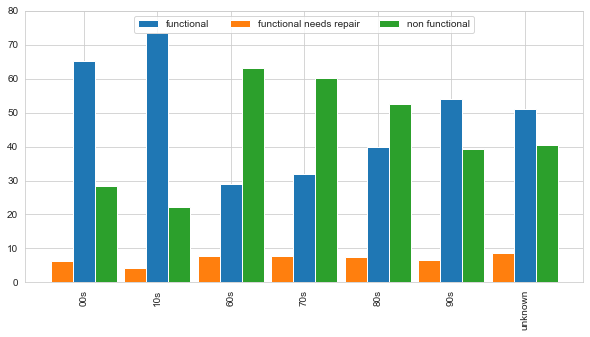

In [340]:
construction_year = [0,1,2,3,4,5,6]
functional = per_con_yr_df['functional']
nr_functional = per_con_yr_df['functional needs repair']
n_functional = per_con_yr_df['non functional']
header = per_con_yr_df.columns.values #an array of columns headers


fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(construction_year)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_ylim(0,80)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='00s'
xlab[1]='10s'
xlab[2]='60s'
xlab[3]='70s'
xlab[4]='80s'
xlab[5]='90s'
xlab[6] ='unknown'




#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)




for tick in ax.get_xticklabels():
    tick.set_rotation(90)



#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   


plt.show()

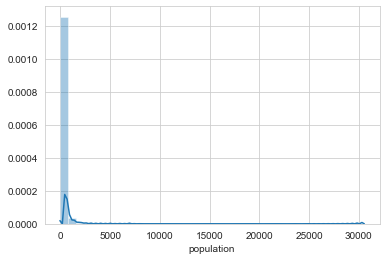

In [341]:
sns.distplot(train_data.population, bins = 40)
plt.show()

In [342]:
# This plot measures the amount of water available at the pump. It looks a lot like the 
# population graph which makes sense. 

train_data.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [343]:
train_data.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [344]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   installer              59400 non-null  object 
 3   basin                  59400 non-null  object 
 4   population             59400 non-null  int64  
 5   public_meeting         59400 non-null  object 
 6   scheme_management      59400 non-null  object 
 7   permit                 59400 non-null  object 
 8   construction_year      59400 non-null  object 
 9   extraction_type_class  59400 non-null  object 
 10  payment_type           59400 non-null  object 
 11  quality_group          59400 non-null  object 
 12  quantity               59400 non-null  object 
 13  source_type            59400 non-null  object 
 14  source_class           59400 non-null  object 
 15  wa

In [345]:
train_data.shape

(59400, 20)

In [346]:
cat_df = train_data.select_dtypes(include='object')



cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   funder                 59400 non-null  object
 1   installer              59400 non-null  object
 2   basin                  59400 non-null  object
 3   public_meeting         59400 non-null  object
 4   scheme_management      59400 non-null  object
 5   permit                 59400 non-null  object
 6   construction_year      59400 non-null  object
 7   extraction_type_class  59400 non-null  object
 8   payment_type           59400 non-null  object
 9   quality_group          59400 non-null  object
 10  quantity               59400 non-null  object
 11  source_type            59400 non-null  object
 12  source_class           59400 non-null  object
 13  waterpoint_type        59400 non-null  object
 14  waterpoint_type_group  59400 non-null  object
 15  status_group       

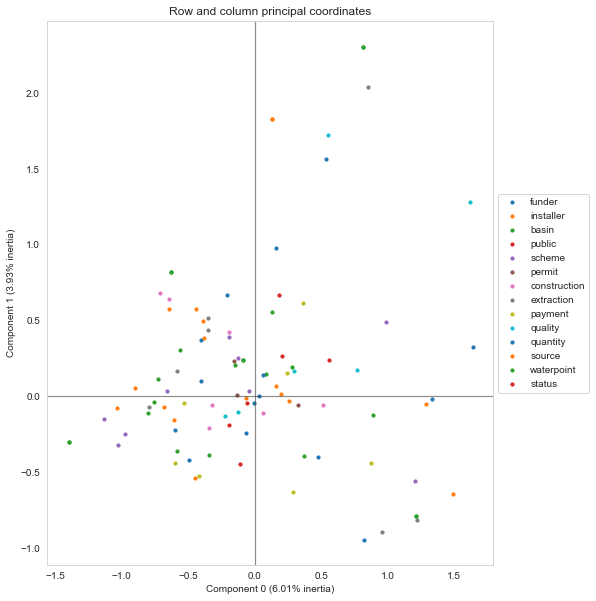

In [347]:
mca = prince.MCA(
        n_components=2,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42
        )
churn_mca = mca.fit(cat_df)

ax = churn_mca.plot_coordinates(
        X=cat_df,
        ax=None,
        figsize=(8, 10),
        show_row_points=False,
        row_points_size=0,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=10,
        show_column_labels=False,
        legend_n_cols=1
               ).legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [348]:
churn2 = pd.get_dummies(cat_df, drop_first=False)

In [349]:
print(churn2.shape)

(59400, 99)


In [350]:
print("The data set contains: {} rows and {} columns".format(churn2.shape[0], churn2.shape[1]))
print("Features after get_dummies:\n", list(churn2.columns))

The data set contains: 59400 rows and 99 columns
Features after get_dummies:
 ['funder_Dis_Council', 'funder_Kkkt', 'funder_Tasaf', 'funder_Unicef', 'funder_danida', 'funder_gov', 'funder_hesawa', 'funder_other', 'funder_rwssp', 'funder_world_bank', 'installer_Hesawa', 'installer_commu', 'installer_danida', 'installer_dwe', 'installer_gov', 'installer_other', 'installer_rwe', 'basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu', 'public_meeting_False', 'public_meeting_True', 'public_meeting_Unknown', 'scheme_management_Parastatal', 'scheme_management_comp', 'scheme_management_other', 'scheme_management_pri_opr', 'scheme_management_vwc', 'scheme_management_wtr_auth', 'scheme_management_wtr_brd', 'scheme_management_wua', 'scheme_management_wug', 'permit_False', 'permit_True', 'permit_Unknown', 'construction_year_00s', 'construction_year_10s', 'constru

In [351]:
y = churn2[['status_group_functional','status_group_functional needs repair', 'status_group_non functional']] # target variable
X = churn2.drop(['status_group_functional','status_group_functional needs repair', 'status_group_non functional'],axis=1) # input categorical features


In [352]:
# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)
# print feature scores
for i in range(len(sf_fit.scores_)):
    print(' %s: %f' % (X.columns[i], sf_fit.scores_[i]))

 funder_Dis_Council: 46.735754
 funder_Kkkt: 8.958172
 funder_Tasaf: 1.443570
 funder_Unicef: 13.285733
 funder_danida: 22.032436
 funder_gov: 694.831216
 funder_hesawa: 130.558801
 funder_other: 288.658764
 funder_rwssp: 14.216822
 funder_world_bank: 116.721629
 installer_Hesawa: 34.531385
 installer_commu: 90.749346
 installer_danida: 3.135005
 installer_dwe: 118.209377
 installer_gov: 482.555852
 installer_other: 104.688615
 installer_rwe: 412.146674
 basin_Internal: 35.530079
 basin_Lake Nyasa: 253.612197
 basin_Lake Rukwa: 191.795267
 basin_Lake Tanganyika: 208.953087
 basin_Lake Victoria: 131.441654
 basin_Pangani: 135.416944
 basin_Rufiji: 275.321373
 basin_Ruvuma / Southern Coast: 586.991201
 basin_Wami / Ruvu: 101.972423
 public_meeting_False: 261.956384
 public_meeting_True: 44.171404
 public_meeting_Unknown: 77.871905
 scheme_management_Parastatal: 83.062192
 scheme_management_comp: 40.577562
 scheme_management_other: 99.258515
 scheme_management_pri_opr: 101.218791
 scheme_

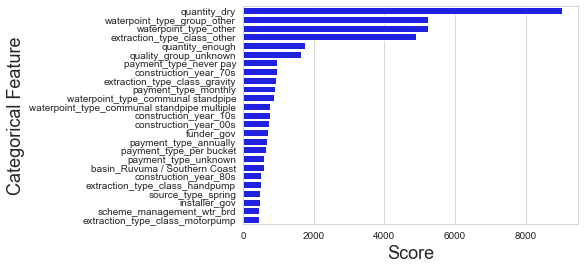

In [353]:
# plot the scores
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)
sns.barplot(datset['scores'][0:25], datset['feature'][0:25], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

In [354]:
feature_list = [i for i in datset['feature'][0:25]]
#num_cols = ['amount_tsh', 'days_since_recorded','population']

#for j in num_cols:
    #feature_list.append(j)

#feature_list



In [355]:
datset['feature'][0:25]

68                                   quantity_dry
95                    waterpoint_type_group_other
89                          waterpoint_type_other
51                    extraction_type_class_other
69                                quantity_enough
67                          quality_group_unknown
57                         payment_type_never pay
44                          construction_year_70s
48                  extraction_type_class_gravity
56                           payment_type_monthly
84             waterpoint_type_communal standpipe
85    waterpoint_type_communal standpipe multiple
42                          construction_year_10s
41                          construction_year_00s
5                                      funder_gov
55                          payment_type_annually
60                        payment_type_per bucket
61                           payment_type_unknown
24                  basin_Ruvuma / Southern Coast
45                          construction_year_80s


In [356]:

train_data['status_group_vals'].value_counts()


2    32259
0    22824
1     4317
Name: status_group_vals, dtype: int64

In [357]:
train_data.drop('status_group',inplace=True,axis=1)

In [358]:
data_train, data_test = train_test_split(train_data, test_size=0.25,random_state=1443,stratify=train_data.status_group_vals)

In [359]:
X_train1 = data_train
y_train = data_train['status_group_vals']


X_test1 = data_test
y_test = data_test['status_group_vals']


In [360]:
X_train = pd.get_dummies(X_train1)
X_train.drop('status_group_vals',inplace=True,axis=1)
X_test = pd.get_dummies(X_test1)
X_test.drop('status_group_vals',inplace=True,axis=1)

In [114]:
X_train.head(5)

,amount_tsh,population,operational_years,funder_Dis_Council,funder_Kkkt,funder_Tasaf,funder_Unicef,funder_danida,funder_gov,funder_hesawa,...,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
40630,0.0,96,50,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
36440,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
25799,0.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
24265,0.0,1,13,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1462,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


gaussian model

In [115]:
gnb = GaussianNB()

In [116]:
gnb.fit(X_train, y_train)

GaussianNB()

In [117]:
y_pred = gnb.predict(X_test)

In [118]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6270707070707071


Multinomial 

In [119]:
clf = MultinomialNB()

In [120]:
clf.fit(X_train, y_train)

MultinomialNB()

In [121]:
y_pred = clf.predict(X_test)

In [122]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4606734006734007


Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
model = RandomForestClassifier(n_estimators=200,max_depth=50, random_state=14400)

In [125]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=200, random_state=14400)

In [126]:
y_pred = model.predict(X_test)

In [127]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7835016835016835


In [367]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,recall_score

def calculate_metrics(y_test, y_pred, y_prob=None, sample_weights=None):
    """Cacluate model performance metrics"""

    # Dictionary of metrics to calculate
    metrics = {}
    metrics['confusion_matrix']  = confusion_matrix(y_test, y_pred, sample_weight=sample_weights)
    metrics['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    metrics['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights,average='weighted')
    metrics['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights,average='weighted')


    return metrics

In [368]:
def conf_mat(metrics):
    '''plot and display the confusion matrix'''
    array = metrics['confusion_matrix']
    classes=['functional','functional need repair','non functional']
    df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap="Blues")
    plt.show()

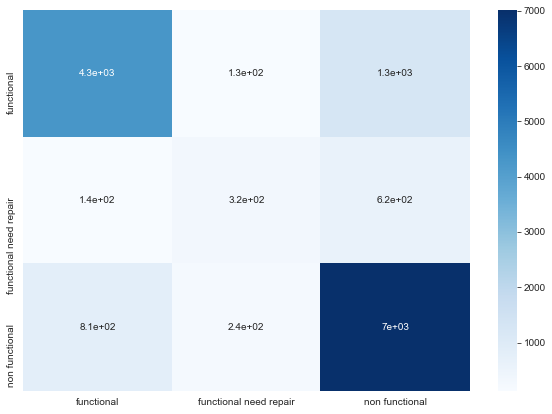

In [130]:
metrics = calculate_metrics(y_test, y_pred)
conf_mat(metrics)

In [113]:
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==0:
            cols.append('green')
        elif l==1:
            cols.append('yellow')
        elif l==2:
            cols.append('red')

    return cols
# Create the colors list using the function above
cols_pred=pltcolor(y_pred)
cols_true=pltcolor(y_test)


(0, 12000)

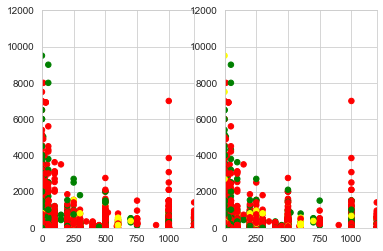

In [114]:
ax1=plt.subplot(1,2,1)
ax1.scatter(X_test1['amount_tsh'],X_test1['population'],c = cols_pred,s=30)
ax1.set_xlim(0,1200)
ax1.set_ylim(0,12000)
ax2=plt.subplot(1,2,2)
ax2.scatter(X_test1['amount_tsh'],X_test1['population'],c = cols_true,s=30)
ax2.set_xlim(0,1200)
ax2.set_ylim(0,12000)


Naive bayes classifier assuming its a Bernaoulli distribution

In [246]:
from sklearn.naive_bayes import BernoulliNB

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


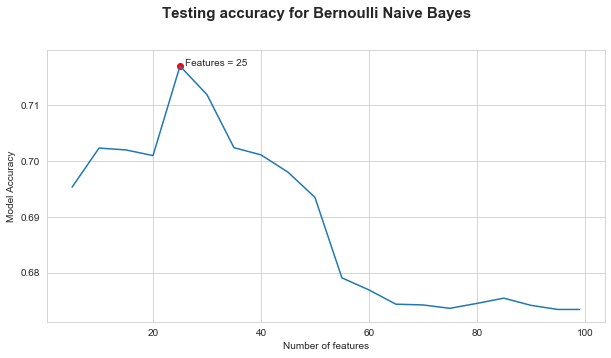

In [247]:
clf1 = BernoulliNB()
test_error = []
feature_num = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
data_train, data_test = train_test_split(train_data, test_size=0.25,random_state=1443,stratify=train_data.status_group_vals)
X_train1 = data_train
y_train = data_train['status_group_vals']
X_test1 = data_test
y_test = data_test['status_group_vals']
X_train1.drop('status_group_vals',inplace=True,axis=1)
X_test1.drop('status_group_vals',inplace=True,axis=1)
#X_train1.drop(['amount_tsh','operational_years','population'], inplace = True,axis=1)
#X_test1.drop(['amount_tsh','operational_years','population'], inplace = True,axis=1)

for i in feature_num:
    feature_list = [k for k in datset['feature'][0:i]]
    #num_cols = ['amount_tsh','operational_years','population']
    #for j in num_cols:
        #feature_list.append(j)
        

        
    # selecting best catagories
    X_train = pd.get_dummies(X_train1)
    X_train = X_train[feature_list]

    X_test = pd.get_dummies(X_test1)
    X_test = X_test[feature_list]
    
    
    
    
    clf1.fit(X_train, y_train)
    
    y_pred = clf1.predict(X_test)
    test_error.append(metrics.accuracy_score(y_test, y_pred))
    
    
fig = plt.figure()
ax = plt.subplot()
ax.plot(feature_num,test_error)
ax.scatter(25, 0.7169696969696969,c='red')
ax.text(26,0.7169696969696969,'Features = 25')
ax.set_xlabel('Number of features')
ax.set_ylabel('Model Accuracy')
#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle('Testing accuracy for Bernoulli Naive Bayes'\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

selecting cotegorical feautres

errors for training and testing

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


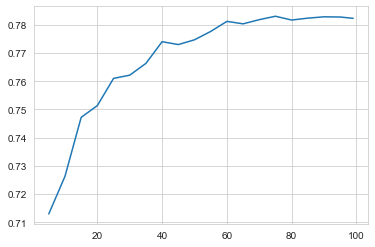

In [123]:
model = RandomForestClassifier(n_estimators=200,max_depth=50, random_state=14400)
test_error = []
feature_num = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
data_train, data_test = train_test_split(train_data, test_size=0.25,random_state=1443,stratify=train_data.status_group_vals)
X_train1 = data_train
y_train = data_train['status_group_vals']
X_test1 = data_test
y_test = data_test['status_group_vals']
X_train1.drop('status_group_vals',inplace=True,axis=1)
X_test1.drop('status_group_vals',inplace=True,axis=1)


for i in feature_num:
    feature_list = [k for k in datset['feature'][0:i]]
    num_cols = ['amount_tsh', 'operational_years','population']
    for j in num_cols:
        feature_list.append(j)
        

        
    # selecting best catagories
    X_train = pd.get_dummies(X_train1)
    X_train = X_train[feature_list]

    X_test = pd.get_dummies(X_test1)
    X_test = X_test[feature_list]
    
    
    
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    test_error.append(metrics.accuracy_score(y_test, y_pred))
    
    

plt.plot(feature_num,test_error)




/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


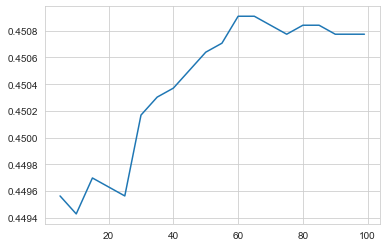

In [218]:
clf = MultinomialNB()
test_error = []
feature_num = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
data_train, data_test = train_test_split(train_data, test_size=0.25,random_state=1443,stratify=train_data.status_group_vals)
X_train1 = data_train
y_train = data_train['status_group_vals']
X_test1 = data_test
y_test = data_test['status_group_vals']
X_train1.drop('status_group_vals',inplace=True,axis=1)
X_test1.drop('status_group_vals',inplace=True,axis=1)

for i in feature_num:
    feature_list = [k for k in datset['feature'][0:i]]
    num_cols = ['amount_tsh', 'days_since_recorded','population']
    for j in num_cols:
        feature_list.append(j)
        

        
    # selecting best catagories
    X_train = pd.get_dummies(X_train1)
    X_train = X_train[feature_list]

    X_test = pd.get_dummies(X_test1)
    X_test = X_test[feature_list]
    
    
    
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    test_error.append(metrics.accuracy_score(y_test, y_pred))
    
    

plt.plot(feature_num,test_error)




In [361]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [371]:
def model(X_train, X_test, y_train, y_test):
    if __name__ == '__main__':
    
        param_grid = {'learning_rate': [0.075, 0.7],
                      'max_depth': [13, 14],
                      'min_samples_leaf': [15, 16],
                      'max_features': [1.0],
                      'n_estimators': [100, 200]}                      

        estimator = GridSearchCV(estimator=GradientBoostingClassifier(),
                                 param_grid=param_grid,
                                 n_jobs=-1)

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_

        print (best_params)
                                 
        y_pred = estimator.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred)
        conf_mat(metrics) 
        return metrics

{'learning_rate': 0.075, 'max_depth': 14, 'max_features': 1.0, 'min_samples_leaf': 15, 'n_estimators': 100}


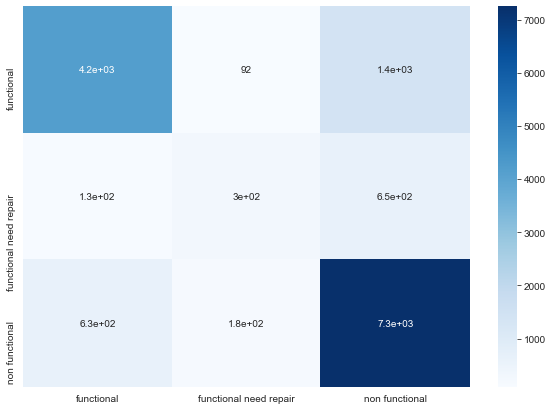

In [372]:
grad=model(X_train, X_test, y_train, y_test)

In [135]:
print("acurracy for gradient boosting classifier",grad)

acurracy for gradient boosting classifier 0.7901683501683502


In [ ]:
def conf_mat(metrics):
    '''plot and display the confusion matrix'''
    array = metrics['confusion_matrix']
    classes=['functional','functional need repair','non functional']
    df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap="Blues")
    plt.show()

In [ ]:
metrics = calculate_metrics(grad)
conf_mat(metrics)

In [486]:
import imblearn
from imblearn.over_sampling import SMOTE
### class Balance Oversampling
from imblearn.over_sampling import SMOTE
# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

X shape after oversampling:  (72582, 99)


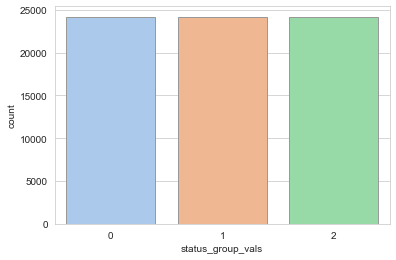

In [276]:
sns.countplot(x=y_train,palette="pastel", edgecolor=".6")